In [1]:
import os
from google.colab import output
from google.colab import drive

using_colab = True

if using_colab:
    drive.mount('/content/drive')
    # %cd /content/drive/Othercomputers/My MacBook Pro/22Spring/CPSC 552/deep_learning_project

Mounted at /content/drive


In [21]:
!cp /content/drive/MyDrive/RRC-60.zip /content
!cd /content
!jar xf RRC-60.zip
!cp /content/drive/MyDrive/lfw-deepfunneled.zip /content
!cd /content
!jar xf lfw-deepfunneled.zip
!cp /content/drive/MyDrive/archive.zip /content
!cd /content
!jar xf archive.zip
!rm -rf data
!mkdir data
!mkdir data/coin
!mkdir data/face
!mv RRC-60/Observe/ data/coin
!mv archive/coins/ data/coin
!mv lfw-deepfunneled/ data/face
!rm RRC-60.zip
!rm archive.zip
!rm lfw-deepfunneled.zip 

In [22]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
save_path = '/content/drive/Othercomputers/My MacBook Pro/22Spring/CPSC 552/deep_learning_project/model.pth'

In [24]:
%run /content/drive/Othercomputers/My\ MacBook\ Pro/22Spring/CPSC\ 552/deep_learning_project/conv_vae.py
model2 = ConVAE()
model2.load_state_dict(torch.load(save_path))
model2 = model2.to(device)
model2.eval()

ConVAE(
  (encConv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (encConv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (encConv3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (encFC1): Linear(in_features=8192, out_features=64, bias=True)
  (encFC2): Linear(in_features=8192, out_features=64, bias=True)
  (decFC1): Linear(in_features=64, out_features=8192, bias=True)
  (decConv3): ConvTranspose2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (decConv2): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (decConv1): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsampling): Upsample(scale_factor=2.0, mode=nearest)
)

<Figure size 432x288 with 0 Axes>

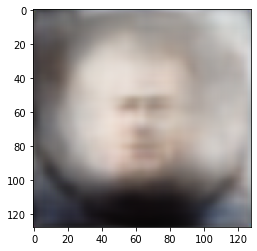

In [34]:
import matplotlib.pyplot as plt
model2.eval()
with torch.no_grad():
    # sample = torch.randn(16, 3, 127, 127).to(device)
    # sample = model(sample)[0].cpu()
    sample = 1 * torch.randn(1, 64).to(device)
    sample = model2.decoder(sample).cpu()
    plt.figure()
    plt.imshow(sample[0].permute(1, 2, 0).squeeze())

In [35]:
import torch
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class ImgPrep:
    def __init__(self):
        pass
    def __call__(self, x):
        # x = TF.to_grayscale(x)
        # x = TF.adjust_sharpness(x, 10)
        x = TF.adjust_contrast(x, 2)
        x = TF.autocontrast(x)
        # x = TF.gaussian_blur(x, 3)
        x = TF.equalize(x)
        # x = TF.posterize(x, 1)
        return x

transform = transforms.Compose([transforms.Resize(128),
                                transforms.CenterCrop(128),
                                ImgPrep(),
                                transforms.ToTensor(),
                                ])

def get_dataloader(path, batch_size):
    dataset = datasets.ImageFolder(path, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

In [36]:
# dl_mix = get_dataloader('data/', 1000)
dl_coin = get_dataloader('data/coin', 1000)
# dl_face = get_dataloader('lfw-deepfunneled/', 1000)
dl_face = get_dataloader('data/face', 1000)

In [37]:
with torch.no_grad():
    # img_m, _ = next(iter(dl_mix))
    # img_m = img_m.to(device)
    # mu_m, logVar_m = model2.encoder(img_m)
    # lat_m = torch.concat([mu_m, logVar_m], axis=1)

    img_c, _ = next(iter(dl_coin))
    img_c = img_c.to(device)
    mu_c, logVar_c = model2.encoder(img_c)
    lat_c = torch.concat([mu_c, logVar_c], axis=1)

    img_f, _ = next(iter(dl_face))
    img_f = img_f.to(device)
    mu_f, logVar_f = model2.encoder(img_f)
    lat_f = torch.concat([mu_f, logVar_f], axis=1)

In [78]:
figpath = '/content/drive/Othercomputers/My MacBook Pro/22Spring/CPSC 552/deep_learning_project/'

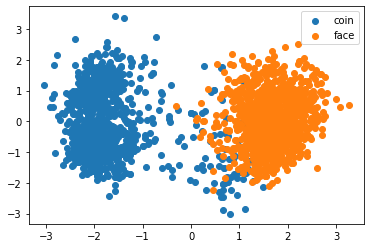

In [92]:
import numpy as np
from sklearn.decomposition import PCA
encoded1, encoded2 = lat_c.cpu().numpy(), lat_f.cpu().numpy()
n1 = encoded1.shape[0]
encoded = np.r_[encoded1, encoded2]
pca = PCA(n_components=2)
dim_red = pca.fit_transform(encoded)
n = encoded.shape[0]
plt.figure()
plt.scatter(dim_red[:n1, 0], dim_red[:n1, 1], label='coin')
plt.scatter(dim_red[n1:, 0], dim_red[n1:, 1], label='face')
plt.legend()
fig1 = plt.gcf()
plt.show()
fig1.savefig(figpath + 'latent_pc2.png')

In [41]:
def GetAttributeShiftVec(model, data_from, data_to):
    # Your code here
    model.eval()
    with torch.no_grad():
        encoded_from = torch.concat((model.encoder(data_from)), axis=1)
        encoded_to = torch.concat(model.encoder(data_to), axis=1)
        mean_from = encoded_from.mean(axis=0)
        mean_to = encoded_to.mean(axis=0)
        return (mean_to - mean_from)

def ShiftImgN(model, imgs, shift_vec, lam, N):
    encoded_from = torch.concat((model.encoder(imgs)), axis=1)
    encoded_shifted = encoded_from + shift_vec.reshape(1,-1) * lam
    pic_outputs = []
    for i in range(N):
        pic_output = model.decoder(model2.reparameterize(encoded_shifted[:, :64], encoded_shifted[:, 64:]))
        pic_outputs.append(pic_output)
    return pic_outputs

In [93]:
import matplotlib.pyplot as plt
model2.eval()
with torch.no_grad():
    # sample = torch.randn(16, 3, 127, 127).to(device)
    # sample = model(sample)[0].cpu()
    sample = 1 * torch.randn(100, 64).to(device)
    sample = model2.decoder(sample).cpu()
fig, axes = plt.subplots(10, 10, figsize=(10, 10), dpi=300)
for i in range(10):
    for j in range(10):
        im = axes[i, j].imshow(sample[i * 10 + j].permute(1, 2, 0))
        axes[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
fig1 = plt.gcf()
plt.show()
fig1.savefig(figpath + 'sample.png')

Output hidden; open in https://colab.research.google.com to view.

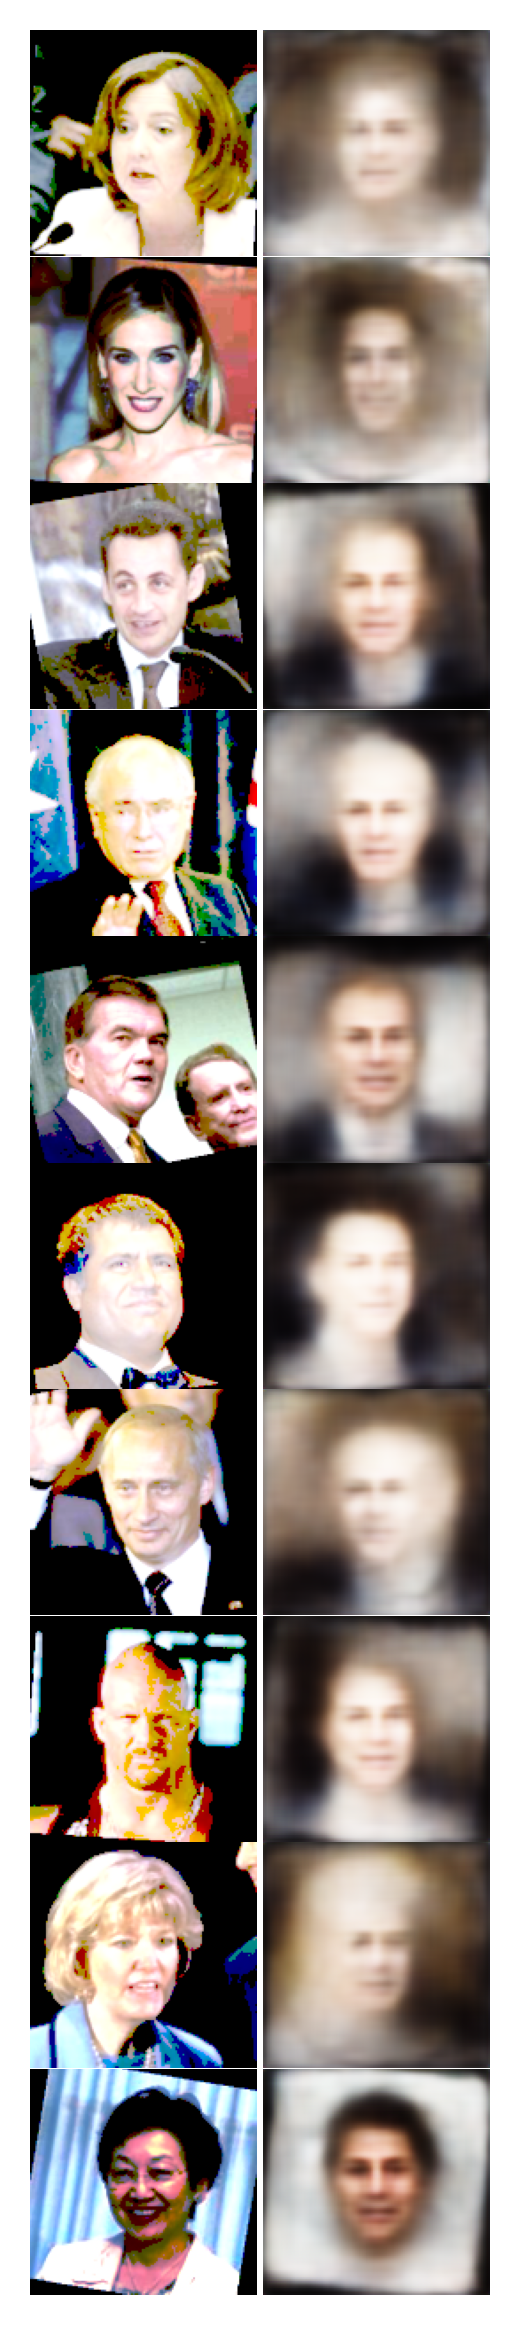

In [94]:
img_recon = model2(img_f[:10, :])
fig, axes = plt.subplots(10, 2, figsize=(2, 10), dpi=300)
for i in range(10):
        im = axes[i, 0].imshow(img_f[i].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 1].imshow(img_recon[0][i].permute(1, 2, 0).detach().squeeze().cpu().numpy())
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
fig1 = plt.gcf()
plt.show()
fig1.savefig(figpath + 'reconstr_face.png')


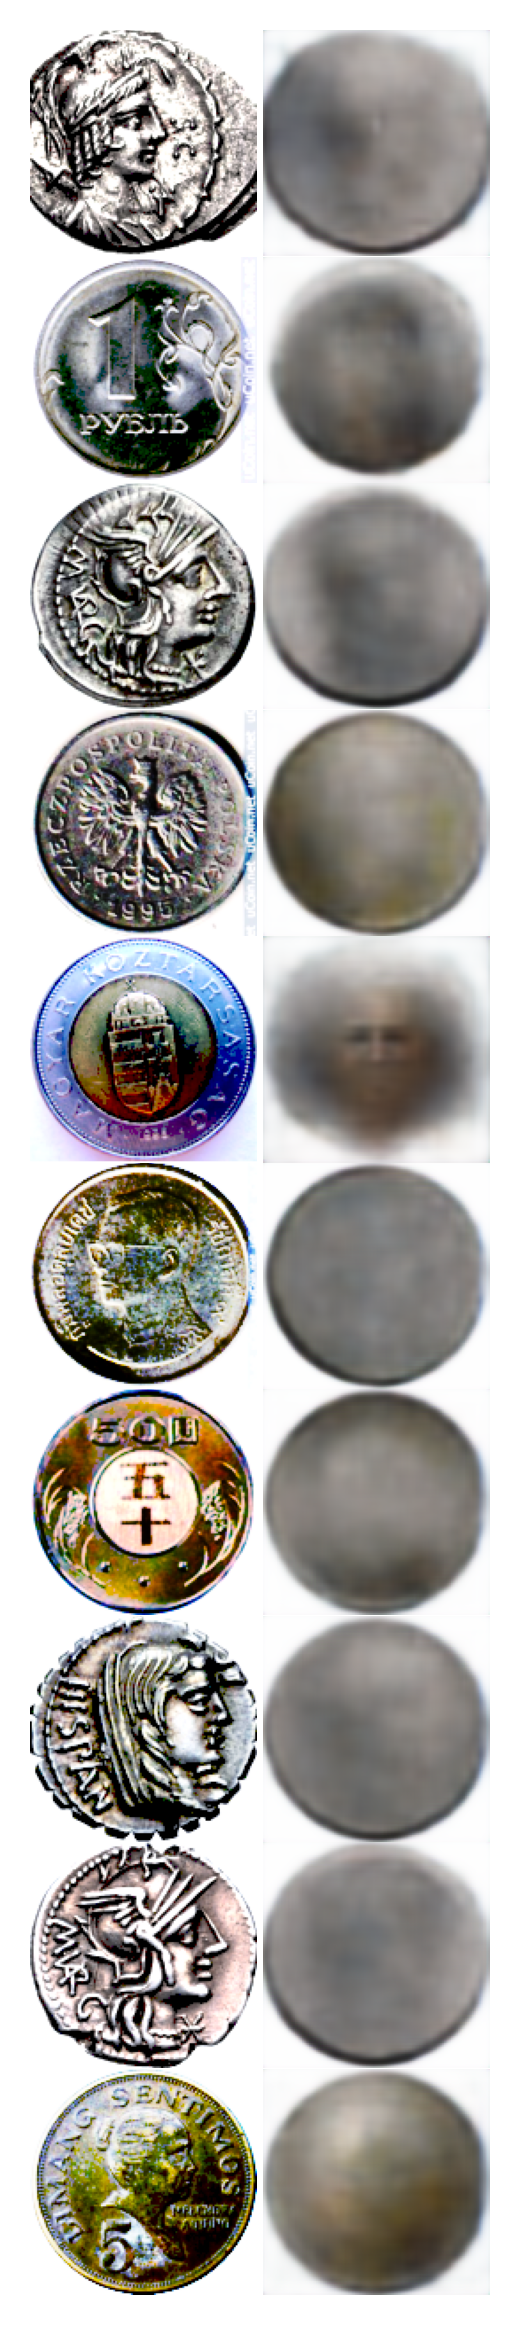

In [95]:
img_recon = model2(img_c[:10, :])
fig, axes = plt.subplots(10, 2, figsize=(2, 10), dpi=300)
for i in range(10):
        im = axes[i, 0].imshow(img_c[i].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 1].imshow(img_recon[0][i].permute(1, 2, 0).detach().squeeze().cpu().numpy())
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
fig1 = plt.gcf()
plt.show()
fig1.savefig(figpath + 'reconstr_coin.png')


In [96]:
for k in range(11):
    shiftVec = GetAttributeShiftVec(model2, img_f, img_c)
    face_to_coin_imgs = ShiftImgN(model2, img_f[:10, :], shiftVec, 0.1 * k, 10)
    fig, axes = plt.subplots(10, 20, figsize=(20, 10), dpi=300)
    for i in range(10):
        for j in range(10):
            im = axes[i, 2 * j].imshow(img_f[j].permute(1, 2, 0).squeeze().cpu().numpy())
            im = axes[i , 2 * j + 1].imshow(face_to_coin_imgs[i][j].permute(1, 2, 0).squeeze().detach().cpu().numpy())
            axes[i, 2 * j].axis('off')
            axes[i, 2 * j + 1].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    fig1 = plt.gcf()
    fig1.savefig(figpath + 'f2c0.' + str(k) + '.png')

In [86]:
shiftVec = GetAttributeShiftVec(model2, img_f, img_c)
face_to_coin_imgs = ShiftImgN(model2, img_f[:10, :], shiftVec, 0.5, 10)
fig, axes = plt.subplots(10, 20, figsize=(20, 10), dpi=300)
for i in range(10):
    for j in range(10):
        im = axes[i, 2 * j].imshow(img_f[j].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 2 * j + 1].imshow(face_to_coin_imgs[i][j].permute(1, 2, 0).squeeze().detach().cpu().numpy())
        axes[i, 2 * j].axis('off')
        axes[i, 2 * j + 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.savefig(figpath + 'f2c0.5.png')

Output hidden; open in https://colab.research.google.com to view.

In [87]:
shiftVec = GetAttributeShiftVec(model2, img_f, img_c)
face_to_coin_imgs = ShiftImgN(model2, img_f[:10, :], shiftVec, 0.6, 10)
fig, axes = plt.subplots(10, 20, figsize=(20, 10), dpi=300)
for i in range(10):
    for j in range(10):
        im = axes[i, 2 * j].imshow(img_f[j].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 2 * j + 1].imshow(face_to_coin_imgs[i][j].permute(1, 2, 0).squeeze().detach().cpu().numpy())
        axes[i, 2 * j].axis('off')
        axes[i, 2 * j + 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.savefig(figpath + 'f2c0.6.png')

Output hidden; open in https://colab.research.google.com to view.

In [88]:
shiftVec = GetAttributeShiftVec(model2, img_f, img_c)
face_to_coin_imgs = ShiftImgN(model2, img_f[:10, :], shiftVec, 0.7, 10)
fig, axes = plt.subplots(10, 20, figsize=(20, 10), dpi=300)
for i in range(10):
    for j in range(10):
        im = axes[i, 2 * j].imshow(img_f[j].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 2 * j + 1].imshow(face_to_coin_imgs[i][j].permute(1, 2, 0).squeeze().detach().cpu().numpy())
        axes[i, 2 * j].axis('off')
        axes[i, 2 * j + 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.savefig(figpath + 'f2c0.7.png')

Output hidden; open in https://colab.research.google.com to view.

In [89]:
shiftVec = GetAttributeShiftVec(model2, img_f, img_c)
face_to_coin_imgs = ShiftImgN(model2, img_f[:10, :], shiftVec, 0.8, 10)
fig, axes = plt.subplots(10, 20, figsize=(20, 10), dpi=300)
for i in range(10):
    for j in range(10):
        im = axes[i, 2 * j].imshow(img_f[j].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 2 * j + 1].imshow(face_to_coin_imgs[i][j].permute(1, 2, 0).squeeze().detach().cpu().numpy())
        axes[i, 2 * j].axis('off')
        axes[i, 2 * j + 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.savefig(figpath + 'f2c0.8.png')

Output hidden; open in https://colab.research.google.com to view.

In [90]:
shiftVec = GetAttributeShiftVec(model2, img_f, img_c)
face_to_coin_imgs = ShiftImgN(model2, img_f[:10, :], shiftVec, 0.9, 10)
fig, axes = plt.subplots(10, 20, figsize=(20, 10), dpi=300)
for i in range(10):
    for j in range(10):
        im = axes[i, 2 * j].imshow(img_f[j].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 2 * j + 1].imshow(face_to_coin_imgs[i][j].permute(1, 2, 0).squeeze().detach().cpu().numpy())
        axes[i, 2 * j].axis('off')
        axes[i, 2 * j + 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.savefig(figpath + 'f2c0.9.png')

Output hidden; open in https://colab.research.google.com to view.

In [91]:
shiftVec = GetAttributeShiftVec(model2, img_f, img_c)
face_to_coin_imgs = ShiftImgN(model2, img_f[:10, :], shiftVec, 1, 10)
fig, axes = plt.subplots(10, 20, figsize=(20, 10), dpi=300)
for i in range(10):
    for j in range(10):
        im = axes[i, 2 * j].imshow(img_f[j].permute(1, 2, 0).squeeze().cpu().numpy())
        im = axes[i , 2 * j + 1].imshow(face_to_coin_imgs[i][j].permute(1, 2, 0).squeeze().detach().cpu().numpy())
        axes[i, 2 * j].axis('off')
        axes[i, 2 * j + 1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
fig1 = plt.gcf()
plt.show()
fig1.savefig(figpath + 'f2c1.png')

Output hidden; open in https://colab.research.google.com to view.

In [39]:
!nvidia-smi

Wed May  4 20:53:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    40W / 250W |   9719MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------